## ERDAP with erddapy example for PMEL tools

***requires python 3.6*** for passing time information (pandas datetime to timestamp doesn't appear to work in 2.7)

### connecting and basic information

In [38]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np

server_url='http://krafla.pmel.noaa.gov:8080/erddap'
e = ERDDAP(server=server_url)

Get only HLY1702 (HE1702) Related files

In [39]:
df = pd.read_csv(e.get_search_url(response='csv', search_for='HLY1702'))

In [40]:
kw = {
    'standard_name': 'sea_water_temperature',
    'min_lon': 180,
    'max_lon': 230,
    'min_lat': 65.0,
    'max_lat': 90.0,
    'min_time': '2015-01-10T00:00:00Z',
    'max_time': '2018-01-10T00:00:00Z'}

In [41]:
hlydata = df['Dataset ID'].values
print(hlydata)

['shiptrack_hly1702' 'CTD_hly1702']


shiptrack datasets are trajectory data, CTD datasets are profile data

In [43]:
variables = [e.get_var_by_attr(dataset_id=data, standard_name=lambda v: v is not None) for data in hlydata]

common_variables 

[['time', 'longitude', 'latitude'], ['time', 'longitude', 'latitude']]

In [58]:
constraints = {
    'longitude>=': kw['min_lon'],
    'longitude<=': kw['max_lon'],
    'latitude>=': kw['min_lat'],
    'latitude<=': kw['max_lat'],
    'time>=': kw['min_time'],
    'time<=': kw['max_time']
}

variables = [
 'T_28',
 'T2_35',
 'S_41',
 'S_42',
 'Fch_906',
 'OST_62',
 'latitude',
 'longitude',
 'pressure',
 'time',
 'station_id'
]

download_url = e.get_download_url(
    dataset_id=hlydata[1],
    protocol='tabledap',
    response='csv',
    variables=variables,
    constraints=constraints
)

print(download_url)

http://krafla.pmel.noaa.gov:8080/erddap/tabledap/CTD_hly1702.csv?T_28,T2_35,S_41,S_42,Fch_906,OST_62,latitude,longitude,pressure,time,station_id&longitude>=180&longitude<=230&latitude>=65.0&latitude<=90.0&time>=1420848000.0&time<=1515542400.0


In [59]:
d = ERDDAP(server=server_url,
           protocol='tabledap',
           response='csv',
           dataset_id=hlydata[1],
           variables=variables,
           constraints=constraints
          )

d.get_download_url()
    

'http://krafla.pmel.noaa.gov:8080/erddap/tabledap/CTD_hly1702.csv?T_28,T2_35,S_41,S_42,Fch_906,OST_62,latitude,longitude,pressure,time,station_id&longitude>=180&longitude<=230&latitude>=65.0&latitude<=90.0&time>=1420848000.0&time<=1515542400.0'

In [61]:
df = d.to_pandas(
    index_col='time',
    parse_dates=True,
    skiprows=(1,)  # units information can be dropped.
).dropna()

df.head()

,T_28,T2_35,S_41,S_42,Fch_906,OST_62,latitude,longitude,pressure,station_id
time,,,,,,,,,,
2017-08-29 15:49:00,6.3035,6.3194,30.00734,29.99379,0.6155,102.023080,67.6765,191.0515,2.0,hly1702c001
2017-08-29 15:49:00,6.3029,6.3151,30.00720,29.99611,0.6091,102.105700,67.6765,191.0515,3.0,hly1702c001
2017-08-29 15:49:00,6.3035,6.2954,30.00622,30.01250,0.5784,102.373970,67.6765,191.0515,4.0,hly1702c001
2017-08-29 15:49:00,6.3042,6.2864,30.00537,30.01944,0.5765,102.346405,67.6765,191.0515,5.0,hly1702c001
2017-08-29 15:49:00,6.3048,6.2883,30.00439,30.01683,0.5714,102.431340,67.6765,191.0515,6.0,hly1702c001


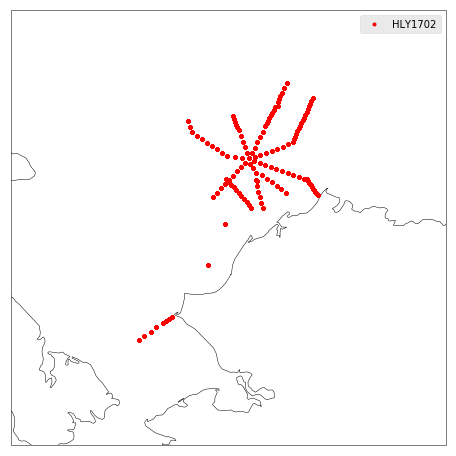

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(8, 8),
                           subplot_kw=dict(projection=projection))
    if projection == ccrs.PlateCarree():
        gl = ax.gridlines(draw_labels=True)
        gl.xlabels_top = gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

projection=ccrs.LambertConformal(central_longitude=-160.0)
transformation=ccrs.PlateCarree()

land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='1.0')

dx = dy = 0.5
extent = -180, -130, kw['min_lat']+dy, kw['max_lat']+dy
extent = [-176, -150, 65, 75]

fig,ax = make_map(projection=projection)
ax.plot(df['longitude'], df['latitude'], 'r.', label='HLY1702', transform=transformation)

leg = ax.legend()

ax.add_feature(land_50m)
ax.coastlines(resolution='50m')
ax.set_extent(extent)

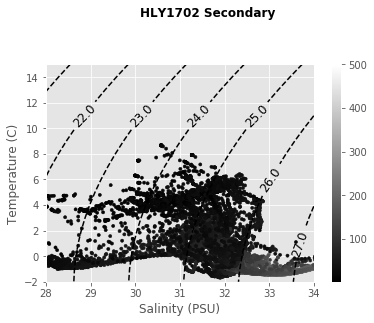

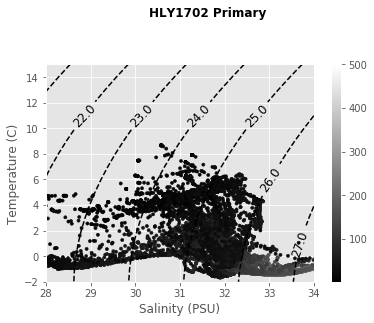

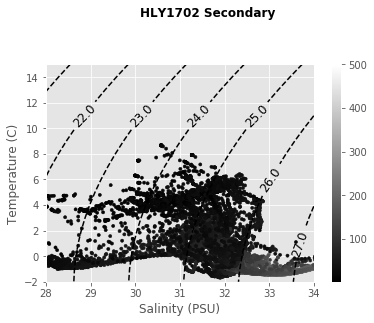

In [65]:
import seawater as sw

def plot_salvtemp(salt, temp, press, srange=[28,34], trange=[-2,15], ptitle=""): 
    plt.style.use('ggplot')
    
    # Figure out boudaries (mins and maxs)
    smin = srange[0]
    smax = srange[1]
    tmin = trange[0]
    tmax = trange[1]

    # Calculate how many gridcells we need in the x and y dimensions
    xdim = int(round((smax-smin)/0.1+1,0))
    ydim = int(round((tmax-tmin)+1,0))
    
    #print 'ydim: ' + str(ydim) + ' xdim: ' + str(xdim) + ' \n'
    if (xdim > 10000) or (ydim > 10000): 
        print('To many dimensions for grid in {cruise} {cast} file. Likely  missing data \n'.format(cruise=cruise,cast=cast))
        return
 
    # Create empty grid of zeros
    dens = np.zeros((ydim,xdim))
 
    # Create temp and salt vectors of appropiate dimensions
    ti = np.linspace(0,ydim-1,ydim)+tmin
    si = np.linspace(0,xdim-1,xdim)*0.1+smin
 
    # Loop to fill in grid with densities
    for j in range(0,int(ydim)):
        for i in range(0, int(xdim)):
            dens[j,i]=sw.dens0(si[i],ti[j])
 
    # Substract 1000 to convert to sigma-t
    dens = dens - 1000
 
    # Plot data ***********************************************
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    CS = plt.contour(si,ti,dens, linestyles='dashed', colors='k')
    plt.clabel(CS, fontsize=12, inline=1, fmt='%1.1f') # Label every second level
 
    ts = ax1.scatter(salt,temp, c=press, cmap='gray', s=10)
    plt.colorbar(ts )
    plt.ylim(tmin,tmax)
    plt.xlim(smin,smax)
 
    ax1.set_xlabel('Salinity (PSU)')
    ax1.set_ylabel('Temperature (C)')

    
    t = fig.suptitle(ptitle, fontsize=12, fontweight='bold')
    t.set_y(1.08)
    return fig  


plot_salvtemp(df['S_41'],df['T_28'],df['pressure'],ptitle='HLY1702 Primary')
plot_salvtemp(df['S_42'],df['T2_35'],df['pressure'],ptitle='HLY1702 Secondary')

